In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt

import DynamicTimeAllocationModel

path = 'output/'

# c++ settings
do_compile = True
threads = 1

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

# Solve and simulate from alternative models

Benchmark model settings

In [2]:
settings = { 
       'T':20,
       'num_A': 10,
       'num_K': 10,
       'num_power': 11,
       'num_love': 10,

       'num_Ctot': 50,

       'phi_w': 1.0,
       'phi_m': 1.0,

       'threads':threads,
       'do_egm': True,
       }

Solve application model

In [3]:
model = DynamicTimeAllocationModel.HouseholdModelClass(par=settings)
model.link_to_cpp(force_compile=do_compile)
%time model.solve()

CPU times: total: 578 ms
Wall time: 573 ms


In [4]:
model.cpp.delink()
model.link_to_cpp(force_compile=do_compile, do_print=False)
model.solve()

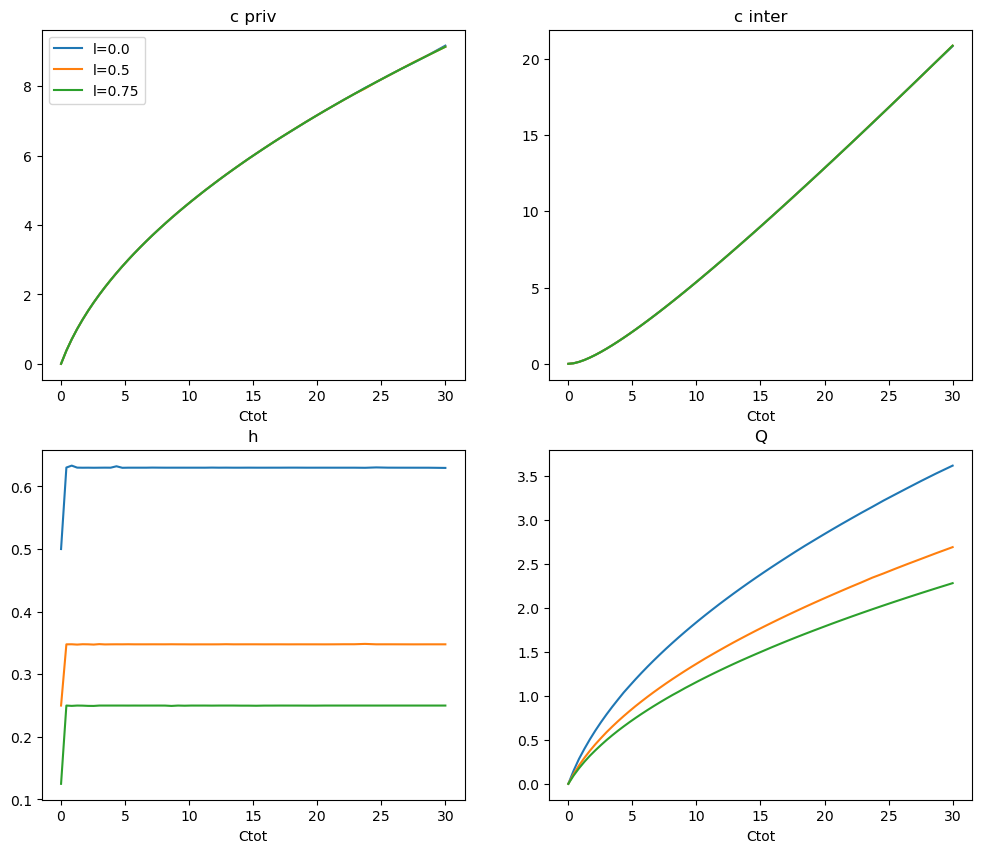

In [6]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

for i,l in enumerate(model.par.grid_l):
    ax[0,0].plot(model.par.grid_Ctot, model.sol.pre_Cw_priv_single[i,:], label=f'l={l}')
    ax[0,0].set_title('c priv')
    ax[0,0].set_xlabel('Ctot')
    ax[0,0].legend()

    ax[0,1].plot(model.par.grid_Ctot, model.sol.pre_Cw_inter_single[i,:], label=f'l={l}')
    ax[0,1].set_title('c inter')
    ax[0,1].set_xlabel('Ctot')

    ax[1,0].plot(model.par.grid_Ctot, model.sol.pre_hw_single[i,:], label=f'l={l}')
    ax[1,0].set_title('h')
    ax[1,0].set_xlabel('Ctot')

    ax[1,1].plot(model.par.grid_Ctot, model.sol.pre_Qw_single[i,:], label=f'l={l}')
    ax[1,1].set_title('Q')
    ax[1,1].set_xlabel('Ctot')

